<a href="https://colab.research.google.com/github/egyvedriyanto78/Forecasting-Experiment/blob/main/LSTM_Gold_Macroeconomic_0001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Experiment with Daily Gold Closing Price and Macroeconomic using LSTM

### Data collection was performed using the Yahoo Finance API and FRED API

Datasets:
- XAU/USD - Gold Price
- DXY - US Dollar Index
- GDP - Gross Domestic Product (GDP)
- CPIAUCSL - Inflation rate / Consumer Price Index
- FEDFUNDS - Interest Rate / Federal Funds Effective Rate
- UNRATE - Unemployment Rate

## Library

In [ ]:
!python --version

Python 3.10.12


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [ ]:
import keras
print(keras.__version__)

3.5.0


In [ ]:
!pip install keras-tuner -q

In [ ]:
# Install yfinance package
!pip install yfinance

In [ ]:
# Install fredapi package
!pip install fredapi

In [ ]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import yfinance as yf
import matplotlib.dates as mdates
import keras_tuner as kt
from fredapi import Fred
from datetime import datetime, timedelta
import math
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA

## Data Collection

### YFinance API

In [ ]:
# Definisikan tanggal awal dan akhir
start_date = "2013-05-03"
end_date = "2023-01-01"

# Ambil data harga emas (GOLD/XAU/USD) dan Dollar Index (DXY) dari Yahoo Finance
gold_data = yf.download("GC=F", start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'GOLD'})
dxy_data = yf.download("DX-Y.NYB", start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'DXY'})

# Ubah index pada data Yahoo Finance menjadi tipe datetime
gold_data.index = pd.to_datetime(gold_data.index)
dxy_data.index = pd.to_datetime(dxy_data.index)

# Reset index untuk membuat kolom tanggal sebagai kolom biasa
gold_data = gold_data.reset_index()
dxy_data = dxy_data.reset_index()

# Ubah nama kolom index menjadi 'Date' agar seragam
gold_data.columns = ['Date', 'GOLD']
dxy_data.columns = ['Date', 'DXY']

# Hapus informasi zona waktu dari kolom 'Date'
gold_data['Date'] = gold_data['Date'].dt.tz_localize(None)
dxy_data['Date'] = dxy_data['Date'].dt.tz_localize(None)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Tampilkan data untuk verifikasi
print(gold_data.head())
print(dxy_data.head())
print(gold_data.tail())
print(dxy_data.tail())

        Date         GOLD
0 2013-05-03  1464.300049
1 2013-05-06  1468.099976
2 2013-05-07  1449.000000
3 2013-05-08  1473.900024
4 2013-05-09  1468.800049
        Date        DXY
0 2013-05-03  82.099998
1 2013-05-06  82.320000
2 2013-05-07  82.300003
3 2013-05-08  81.900002
4 2013-05-09  82.790001
           Date         GOLD
2426 2022-12-23  1795.900024
2427 2022-12-27  1814.800049
2428 2022-12-28  1807.900024
2429 2022-12-29  1819.500000
2430 2022-12-30  1819.699951
           Date         DXY
2428 2022-12-23  104.309998
2429 2022-12-27  104.180000
2430 2022-12-28  104.459999
2431 2022-12-29  103.839996
2432 2022-12-30  103.519997


### FRED Api

In [ ]:
# Inisialisasi FRED API
fred = Fred(api_key='c0032ef6496fbdef7acbc2ef8a82a00c')

# Fetch data makroekonomi dari FRED
gdp_data = fred.get_series("GDP", observation_start=start_date, observation_end=end_date)
cpi_data = fred.get_series("CPILFESL", observation_start=start_date, observation_end=end_date)
fedfunds_data = fred.get_series("FEDFUNDS", observation_start=start_date, observation_end=end_date)
unrate_data = fred.get_series("UNRATE", observation_start=start_date, observation_end=end_date)

# Ubah data menjadi frekuensi harian dengan interpolasi
gdp_data_daily = gdp_data.resample('D').interpolate(method='linear').to_frame("GDP").reset_index().rename(columns={'index': 'Date'})
cpi_data_daily = cpi_data.resample('D').interpolate(method='linear').to_frame("CPI").reset_index().rename(columns={'index': 'Date'})
fedfunds_data_daily = fedfunds_data.resample('D').interpolate(method='linear').to_frame("FEDFUNDS").reset_index().rename(columns={'index': 'Date'})
unrate_data_daily = unrate_data.resample('D').interpolate(method='linear').to_frame("UNRATE").reset_index().rename(columns={'index': 'Date'})

In [ ]:
# Tampilkan data makroekonomi untuk verifikasi
print(gdp_data_daily.head())
print(cpi_data_daily.head())
print(fedfunds_data_daily.head())
print(unrate_data_daily.head())
print(gdp_data_daily.tail())
print(cpi_data_daily.tail())
print(fedfunds_data_daily.tail())
print(unrate_data_daily.tail())

        Date           GDP
0 2013-04-01  16728.687000
1 2013-04-02  16731.161187
2 2013-04-03  16733.635374
3 2013-04-04  16736.109560
4 2013-04-05  16738.583747
        Date         CPI
0 2013-05-01  232.996000
1 2013-05-02  233.007419
2 2013-05-03  233.018839
3 2013-05-04  233.030258
4 2013-05-05  233.041677
        Date  FEDFUNDS
0 2013-05-01  0.110000
1 2013-05-02  0.109355
2 2013-05-03  0.108710
3 2013-05-04  0.108065
4 2013-05-05  0.107419
        Date  UNRATE
0 2013-05-01     7.5
1 2013-05-02     7.5
2 2013-05-03     7.5
3 2013-05-04     7.5
4 2013-05-05     7.5
           Date           GDP
3558 2022-12-28  27145.659783
3559 2022-12-29  27150.334587
3560 2022-12-30  27155.009391
3561 2022-12-31  27159.684196
3562 2023-01-01  27164.359000
           Date         CPI
3528 2022-12-28  302.543065
3529 2022-12-29  302.584548
3530 2022-12-30  302.626032
3531 2022-12-31  302.667516
3532 2023-01-01  302.709000
           Date  FEDFUNDS
3528 2022-12-28  4.300323
3529 2022-12-29  4.30774

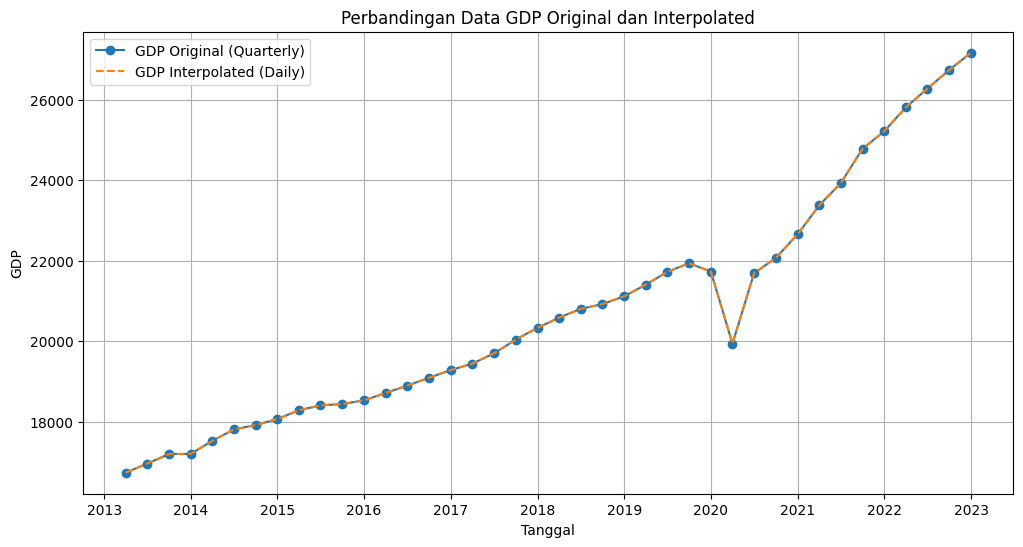

In [ ]:
# Plot data GDP sebelum dan sesudah interpolasi
plt.figure(figsize=(12, 6))
plt.plot(gdp_data.index, gdp_data.values, label="GDP Original (Quarterly)", marker='o')
plt.plot(gdp_data_daily['Date'], gdp_data_daily['GDP'], label="GDP Interpolated (Daily)", linestyle='--')
plt.title("Perbandingan Data GDP Original dan Interpolated")
plt.xlabel("Tanggal")
plt.ylabel("GDP")
plt.legend()
plt.grid()
plt.show()

## Data Merge

In [ ]:
# Merge semua data berdasarkan kolom 'Date'
combined_data = gold_data.merge(dxy_data, on="Date", how='inner') \
                         .merge(gdp_data_daily, on="Date", how='inner') \
                         .merge(cpi_data_daily, on="Date", how='inner') \
                         .merge(fedfunds_data_daily, on="Date", how='inner') \
                         .merge(unrate_data_daily, on="Date", how='inner')

# Tampilkan data terakhir untuk verifikasi
print(combined_data.head())
print(combined_data.tail())

        Date         GOLD        DXY           GDP         CPI  FEDFUNDS  \
0 2013-05-03  1464.300049  82.099998  16807.860978  233.018839  0.108710   
1 2013-05-06  1468.099976  82.320000  16815.283538  233.053097  0.106774   
2 2013-05-07  1449.000000  82.300003  16817.757725  233.064516  0.106129   
3 2013-05-08  1473.900024  81.900002  16820.231912  233.075935  0.105484   
4 2013-05-09  1468.800049  82.790001  16822.706099  233.087355  0.104839   

   UNRATE  
0     7.5  
1     7.5  
2     7.5  
3     7.5  
4     7.5  
           Date         GOLD         DXY           GDP         CPI  FEDFUNDS  \
2426 2022-12-23  1795.900024  104.309998  27122.285761  302.335645  4.263226   
2427 2022-12-27  1814.800049  104.180000  27140.984978  302.501581  4.292903   
2428 2022-12-28  1807.900024  104.459999  27145.659783  302.543065  4.300323   
2429 2022-12-29  1819.500000  103.839996  27150.334587  302.584548  4.307742   
2430 2022-12-30  1819.699951  103.519997  27155.009391  302.626032  4.3

## Exploratory Data Analysis

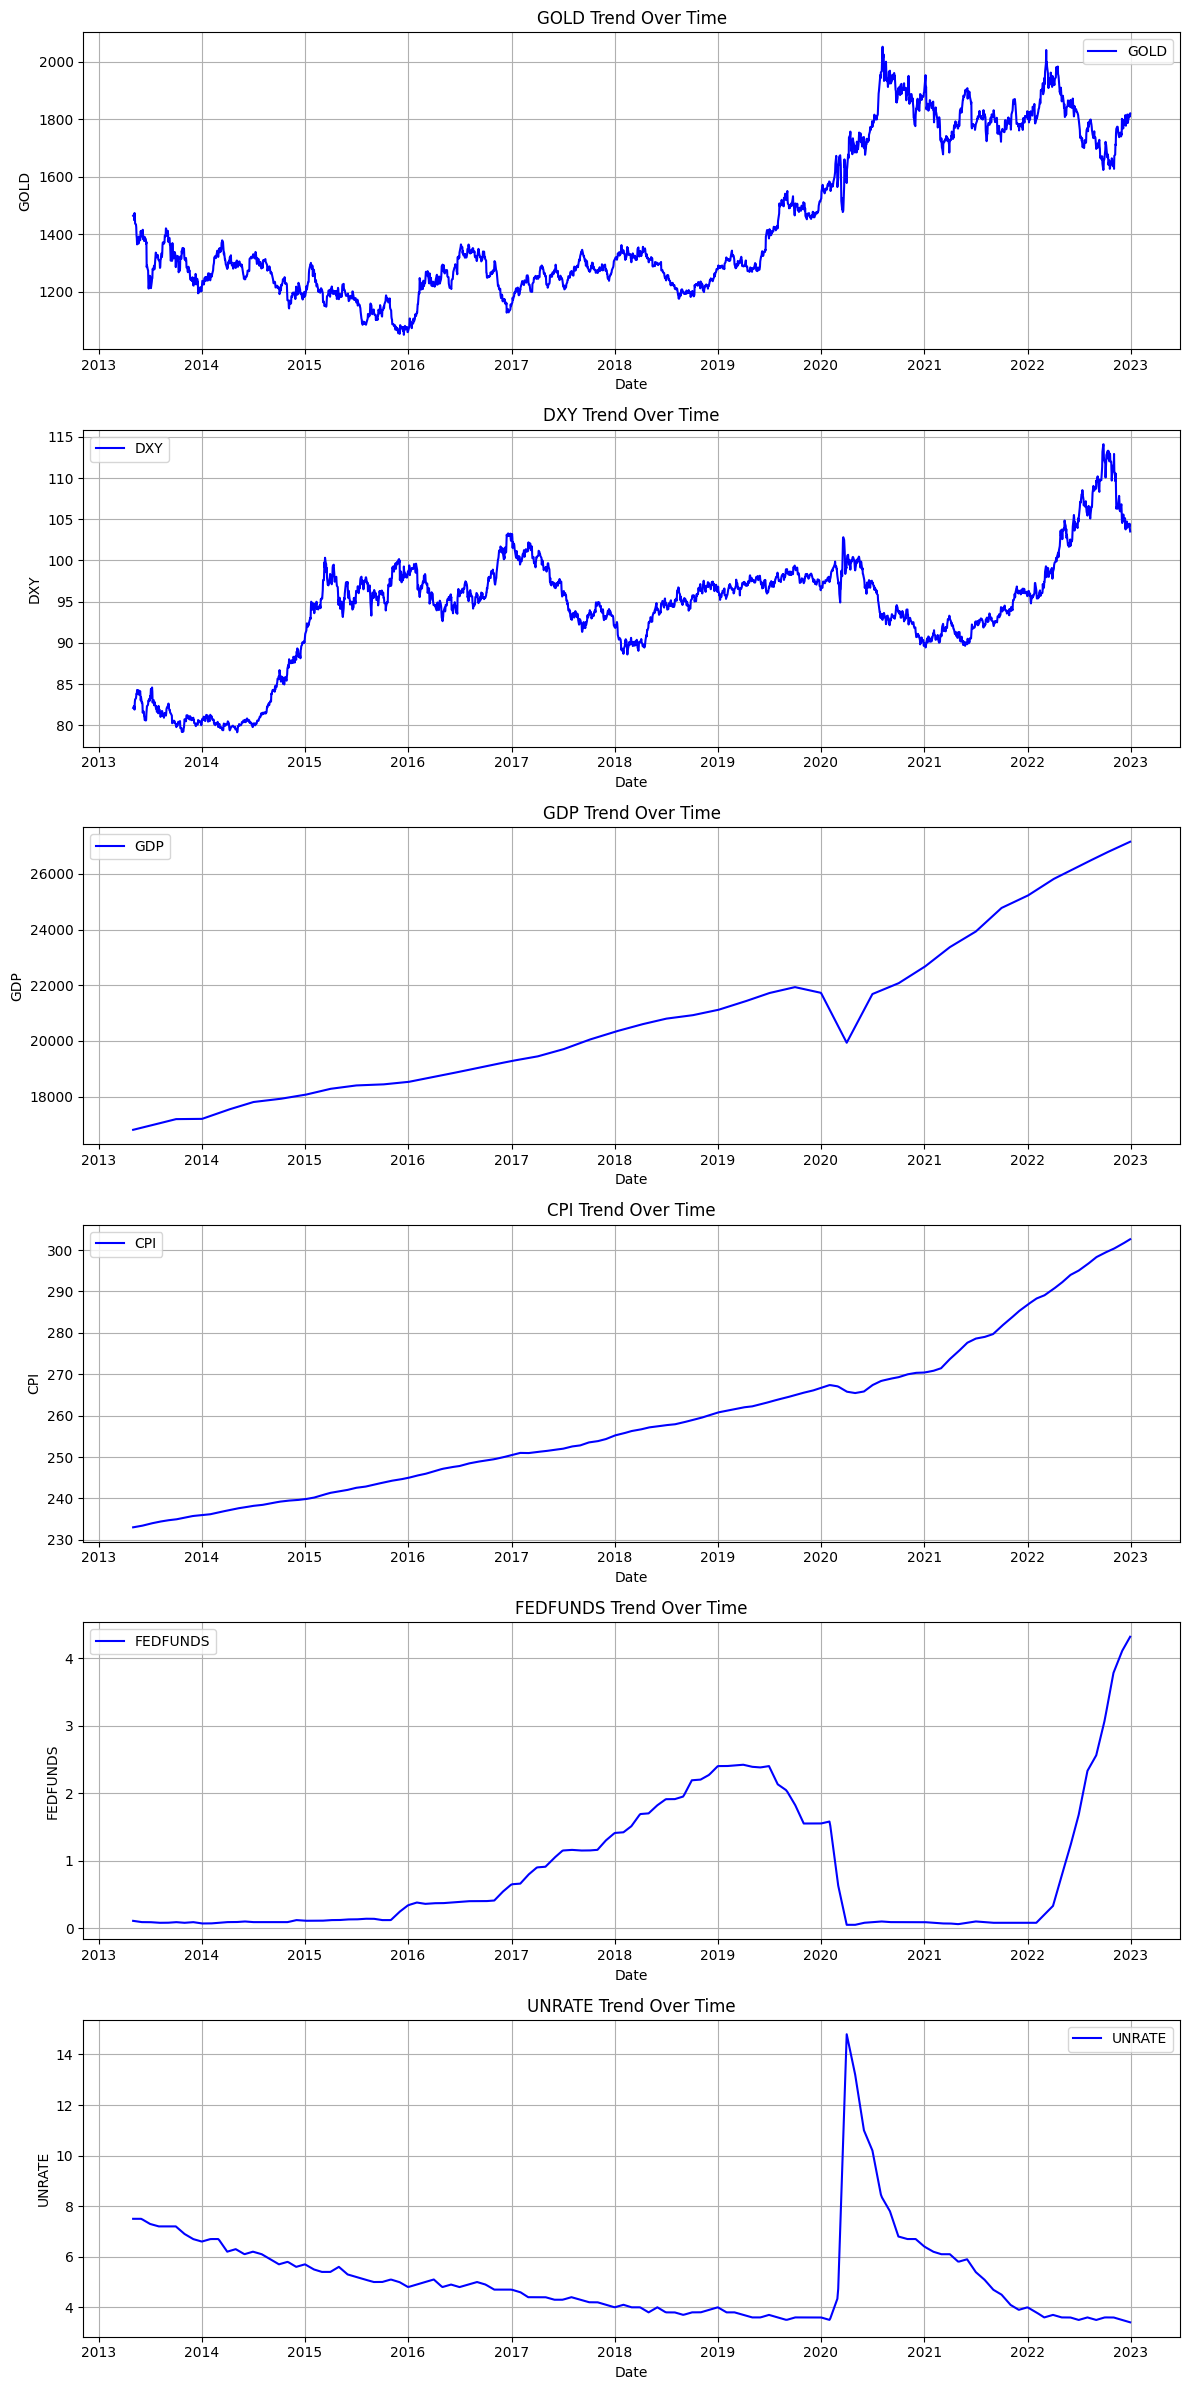


Descriptive Statistics for Gold Price and Macroeconomic Features:
              GOLD          DXY           GDP          CPI     FEDFUNDS  \
count  2431.000000  2431.000000   2431.000000  2431.000000  2431.000000   
mean   1432.334059    94.129868  20712.585308   258.552316     0.825132   
std     258.587679     6.858494   2738.015694    17.893467     0.956146   
min    1050.800049    79.139999  16807.860978   233.018839     0.050000   
25%    1240.000000    91.685001  18434.954875   243.760467     0.090000   
50%    1312.699951    95.320000  20373.416822   256.328903     0.364516   
75%    1714.299988    97.770000  21910.471304   268.431129     1.550000   
max    2051.500000   114.110001  27155.009391   302.626032     4.315161   

            UNRATE  
count  2431.000000  
mean      5.168625  
std       1.778755  
min       3.406452  
25%       3.842356  
50%       4.825806  
75%       5.967258  
max      14.800000  

Number of outliers per feature:
GOLD: 0 outliers
DXY: 371 outliers


In [ ]:
def perform_eda(data, title):
    # Plot tren masing-masing fitur
    features = ['GOLD', 'DXY', 'GDP', 'CPI', 'FEDFUNDS', 'UNRATE']
    plt.figure(figsize=(12, len(features) * 4))

    for i, feature in enumerate(features, start=1):
        plt.subplot(len(features), 1, i)
        plt.plot(data['Date'], data[feature], label=feature, color='blue')
        plt.title(f"{feature} Trend Over Time")
        plt.xlabel("Date")
        plt.ylabel(feature)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Statistik deskriptif (hanya untuk kolom numerik)
    print(f"\nDescriptive Statistics for {title}:")
    print(data[features].describe())

    # Deteksi outlier menggunakan IQR (Interquartile Range)
    outlier_counts = {}
    for column in features:
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1
        outlier_counts[column] = len(data[(data[column] < (q1 - 1.5 * iqr)) | (data[column] > (q3 + 1.5 * iqr))])

    # Tampilkan jumlah outlier untuk setiap fitur
    print("\nNumber of outliers per feature:")
    for feature, count in outlier_counts.items():
        print(f"{feature}: {count} outliers")

# Panggil fungsi EDA
perform_eda(combined_data, "Gold Price and Macroeconomic Features")

## Data Preprocessing

In [ ]:
# Fungsi untuk mempersiapkan data untuk model LSTM dengan PCA
def prepare_gold_data_with_pca(data, window_size=25, n_components=5):
    # Urutkan data berdasarkan tanggal
    data = data.sort_values('Date')

    # Fitur yang digunakan untuk input (termasuk GOLD sebagai fitur historis)
    feature_columns = ['DXY', 'GDP', 'CPI', 'FEDFUNDS', 'UNRATE', 'GOLD']

    # Target yang diprediksi adalah GOLD
    target_column = 'GOLD'

    # Scale data untuk fitur dan target secara terpisah
    scaler_features = RobustScaler()
    scaler_target = RobustScaler()

    # Scaling fitur dan target
    scaled_features = scaler_features.fit_transform(data[feature_columns].values)
    scaled_target = scaler_target.fit_transform(data[target_column].values.reshape(-1, 1))

    # Terapkan PCA untuk mereduksi dimensi fitur
    pca = PCA(n_components=n_components)  # Misalnya 5 komponen utama
    reduced_features = pca.fit_transform(scaled_features)

    X, y = [], []
    for i in range(len(reduced_features) - window_size):
        # Ambil window_size data dari semua fitur yang telah direduksi
        X.append(reduced_features[i:i + window_size])
        # Ambil target pada langkah waktu berikutnya
        y.append(scaled_target[i + window_size, 0])

    X, y = np.array(X), np.array(y)
    return X, y, scaler_features, scaler_target, pca

# Fungsi untuk membuat sequence dari data ter-*scale*
def create_gold_sequences(scaled_features, scaled_target, window_size):
    X, y = [], []
    for i in range(len(scaled_features) - window_size):
        X.append(scaled_features[i:i + window_size])
        y.append(scaled_target[i + window_size, 0])
    X, y = np.array(X), np.array(y)
    return X, y

In [ ]:
def plot_pca_explained_variance(data, feature_columns, title="PCA Explained Variance", n_components=5):
    # Scaling data
    scaler_features = RobustScaler()
    scaled_features = scaler_features.fit_transform(data[feature_columns].values)

    # Fit PCA
    pca = PCA(n_components=n_components)
    pca.fit(scaled_features)

    # Explained variance
    explained_variance = pca.explained_variance_ratio_

    # Plot cumulative explained variance
    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--', color='b')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(title)
    plt.grid()
    plt.show()

## Modeling

### Modeling -


> Building Model

In [ ]:
# Fungsi untuk membangun model LSTM dengan hyperparameter tuning
def build_gold_model(hp):
    model = Sequential()

    # Tambahkan layer pertama LSTM
    model.add(LSTM(
        units=hp.Int('lstm_units_1', min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=(None, 6)  # Jumlah fitur input (termasuk GOLD sebagai fitur historis)
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Tambahkan beberapa lapisan LSTM tambahan berdasarkan jumlah layer yang dipilih
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(LSTM(
            units=hp.Int(f'lstm_units_{i+2}', min_value=32, max_value=128, step=32),
            return_sequences=(i < hp.Int('num_layers', 2, 4) - 1)
        ))
        model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0.1, max_value=0.5, step=0.1)))

    # Lapisan output
    model.add(Dense(units=1))

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

### Modeling - -

> Hyperparameter Tuning


> Training Set Model

In [ ]:
# Fungsi untuk melakukan cross-validation dengan hyperparameter tuning menggunakan PCA
def cross_validate_gold_with_pca(data, window_size=25, epochs=50, batch_size=32, n_splits=5, n_components=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold = 1

    # Siapkan scaler dan PCA
    scaler_features = RobustScaler()
    scaler_target = RobustScaler()
    pca = PCA(n_components=n_components)

    # Siapkan data awal untuk hyperparameter tuning
    feature_columns = ['DXY', 'GDP', 'CPI', 'FEDFUNDS', 'UNRATE', 'GOLD']
    target_column = 'GOLD'

    plot_pca_explained_variance(
        data=data,
        feature_columns=feature_columns,
        title="PCA Explained Variance per Fold",
        n_components=5
    )

    # Scale dan reduksi dimensi untuk semua data
    scaled_features = scaler_features.fit_transform(data[feature_columns].values)
    reduced_features = pca.fit_transform(scaled_features)
    scaled_target = scaler_target.fit_transform(data[target_column].values.reshape(-1, 1))

    # Buat sequence data awal untuk hyperparameter tuning
    X, y = create_gold_sequences(reduced_features, scaled_target, window_size)

    # Hyperparameter tuning menggunakan Keras Tuner
    tuner = kt.RandomSearch(
        build_gold_model,
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        directory='keras_tuner_dir',
        project_name='gold_price_prediction'
    )
    tuner.search(X, y, epochs=epochs, validation_split=0.2, batch_size=batch_size, verbose=0)
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best Hyperparameters: {best_hp.values}")

    # Iterasi melalui setiap fold cross-validation
    for train_index, test_index in tscv.split(data):
        print(f"\nProcessing Fold {fold}:\n")

        # Split data untuk fold ini
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]

        # Scale dan reduksi dimensi data per fold
        scaled_train_features = scaler_features.fit_transform(train_data[feature_columns].values)
        reduced_train_features = pca.fit_transform(scaled_train_features)
        scaled_train_target = scaler_target.fit_transform(train_data[target_column].values.reshape(-1, 1))

        scaled_test_features = scaler_features.transform(test_data[feature_columns].values)
        reduced_test_features = pca.transform(scaled_test_features)
        scaled_test_target = scaler_target.transform(test_data[target_column].values.reshape(-1, 1))

        # Buat sequence data
        X_train, y_train = create_gold_sequences(reduced_train_features, scaled_train_target, window_size)
        X_test, y_test = create_gold_sequences(reduced_test_features, scaled_test_target, window_size)

        # Buat model dengan hyperparameter terbaik
        model = tuner.hypermodel.build(best_hp)

        # Latih model
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

        # Lakukan prediksi pada data uji
        y_pred_scaled = model.predict(X_test)
        y_pred = scaler_target.inverse_transform(y_pred_scaled)
        y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1))

        # Evaluasi performa model
        mse = mean_squared_error(y_test, y_pred)
        rmse = math.sqrt(mse)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        r2 = r2_score(y_test, y_pred)

        print(f"\nMetrics for Fold {fold}:")
        print(f"RMSE: {rmse}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R-squared (R2): {r2:.2f}")

        # Plot prediksi pada fold terakhir
        if fold == n_splits:
            plot_gold_predictions(data, y_test, y_pred, title=f"Gold Price Prediction Fold {fold}")

        fold += 1

### Modeling - - -


> Plotting Model

In [ ]:
# Fungsi untuk memplot hasil prediksi dan data aktual
def plot_gold_predictions(data, y_test, y_pred, title="Gold Price Prediction"):
    # Ambil tanggal untuk data uji
    test_dates = data['Date'].iloc[len(data) - len(y_test):].reset_index(drop=True)

    # Plot data aktual dan prediksi
    plt.figure(figsize=(12, 6), dpi=100)
    plt.plot(data['Date'], data['GOLD'], label='Actual Gold Price', color='blue')
    plt.plot(test_dates, y_pred, label='Predicted Gold Price', color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Gold Price (USD)')
    plt.legend()
    plt.grid()
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Label sumbu X per tahun
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gcf().autofmt_xdate()  # Rotasi label sumbu X
    plt.show()

### Modeling - - - -


> Running Model

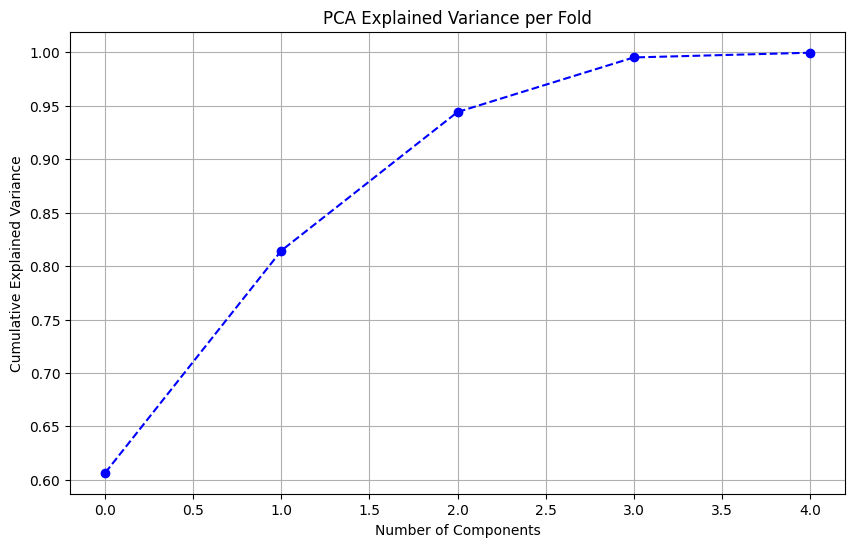

Reloading Tuner from keras_tuner_dir/gold_price_prediction/tuner0.json
Best Hyperparameters: {'lstm_units_1': 128, 'dropout_1': 0.4, 'num_layers': 2, 'lstm_units_2': 128, 'dropout_2': 0.4, 'lstm_units_3': 32, 'dropout_3': 0.4, 'lstm_units_4': 32, 'dropout_4': 0.4, 'lstm_units_5': 96, 'dropout_5': 0.1}

Processing Fold 1:

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3601
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1762
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1375
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1153
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1079
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1059
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0926
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0885
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0788
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0734 
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0807
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0782
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0636
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0693
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0652
Epoch 16/50
12/12 ━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2343
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0942
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0799
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0643
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0567
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0569
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0562
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0484
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0426
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0532
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0505
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0415
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0418
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0456
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0433
Epoch 16/50
25/25 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2061
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0788
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0665
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0586
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0483
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0465
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0472
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0455
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0449
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0441
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0365
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0436
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0341
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0373
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0403
Epoch 16/50
38/38

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2516
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0795
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0651
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0604
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0557
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0531
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0486
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0465
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0501
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0455
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0433
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0439
Epoch 13/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0410
Epoch 14/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0407
Epoch 15/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0444
Epoch 16/50
50/50 ━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.4677
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1099
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0781
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0975
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0847
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0726
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0847
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0714
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0705
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0628
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0667
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0671
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0756
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0650
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0654
Epoch 16/50
63/63 ━━━━━━━━━━

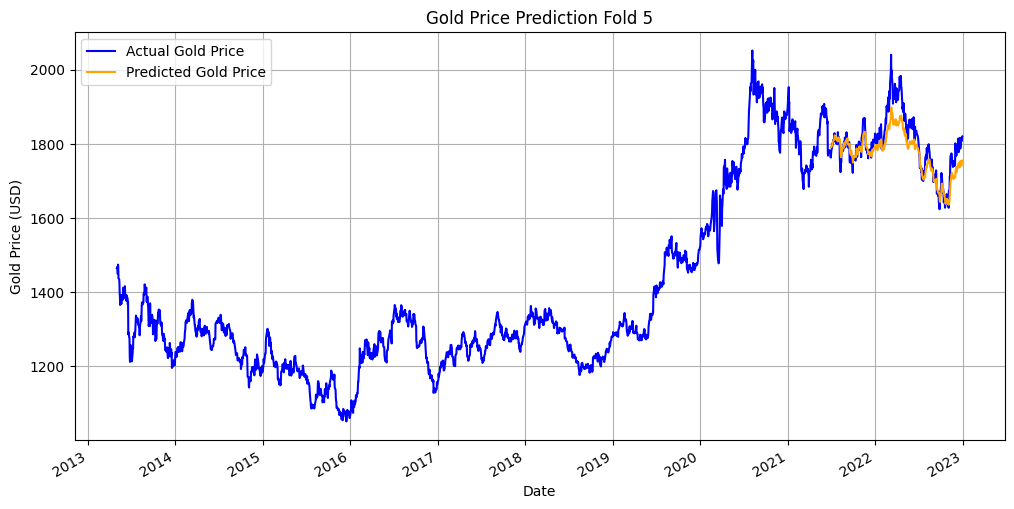

In [ ]:
# Jalankan Cross-Validation
cross_validate_gold_with_pca(combined_data, window_size=25, epochs=50, batch_size=32, n_splits=5)